In [24]:
# Depth image to normal vector
import os
from glob import glob
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

CASE_NAME = "bmvs_bear"

rgb_imgs = glob(f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/{CASE_NAME}/image/*.png")   # Get the list of images
depth_imgs = glob(f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/{CASE_NAME}/depth/*.png")   # Get the list of images
normal_save_dir = f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/dataset/{CASE_NAME}/normal_estim"
normal_mask_dir = f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/dataset/{CASE_NAME}/norm_mask"

print(CASE_NAME)

# with open(f'/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/dataset/{CASE_NAME}/params.json') as f:
#     data = json.load(f)
# intrinsic = data['K']

os.makedirs(normal_save_dir, exist_ok=True)

bmvs_bear


In [31]:
# Depth image to normal vector
import os
from glob import glob
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

CASE_NAME = "bmvs_bear"

depth_imgs = glob(f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/dataset/{CASE_NAME}/depth/*.png")   # Get the list of images
normal_save_dir = f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/dataset/{CASE_NAME}/normal_estim"
normal_mask_dir = f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/dataset/{CASE_NAME}/norm_mask"

print(CASE_NAME)

with open(f'/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/dataset/{CASE_NAME}/params.json') as f:
    data = json.load(f)
intrinsic = data['K']

os.makedirs(normal_save_dir, exist_ok=True)

bmvs_bear


FileNotFoundError: [Errno 2] No such file or directory: '/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/dataset/bmvs_bear/params.json'

In [37]:
CASE_NAME = "cow"
with open(f'/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/dataset/{CASE_NAME}/params.json') as f:
    data = json.load(f)
data['gt_normal_world']

False

In [12]:


def get_normal_map_by_point_cloud(depth, K, save_point_cloud=False):
    height, width = depth.shape

    x, y = np.meshgrid(np.arange(0, width), np.arange(0, height))
    x = x.reshape([-1])
    y = y.reshape([-1])
    xyz = np.vstack((x, y, np.ones_like(x)))
    pts_3d = np.dot(np.linalg.inv(K), xyz * depth.reshape([-1]))
    pts_3d = pts_3d.reshape((3, height, width))

    if(save_point_cloud):
        np.savetxt(f'point_cloud_{CASE_NAME}.xyz', pts_3d.reshape(3, -1).T, delimiter=' ')

    f = (
        pts_3d[:, 1 : height - 1, 2 : width]
        - pts_3d[:, 1 : height - 1, 1 : width - 1]
    )
    t = (
        pts_3d[:, 2:height, 1 : width - 1]
        - pts_3d[:, 1 : height - 1, 1 : width - 1]
    )

    normal_map = np.cross(f, t, axisa=0, axisb=0)
    # print(f"Normalization shape: {np.linalg.norm(normal_map, axis=-1, keepdims=True)}")
    normal_map = normalization(normal_map)

    return normal_map


vis_normal = lambda normal: np.uint8((normal + 1) / 2 * 255)


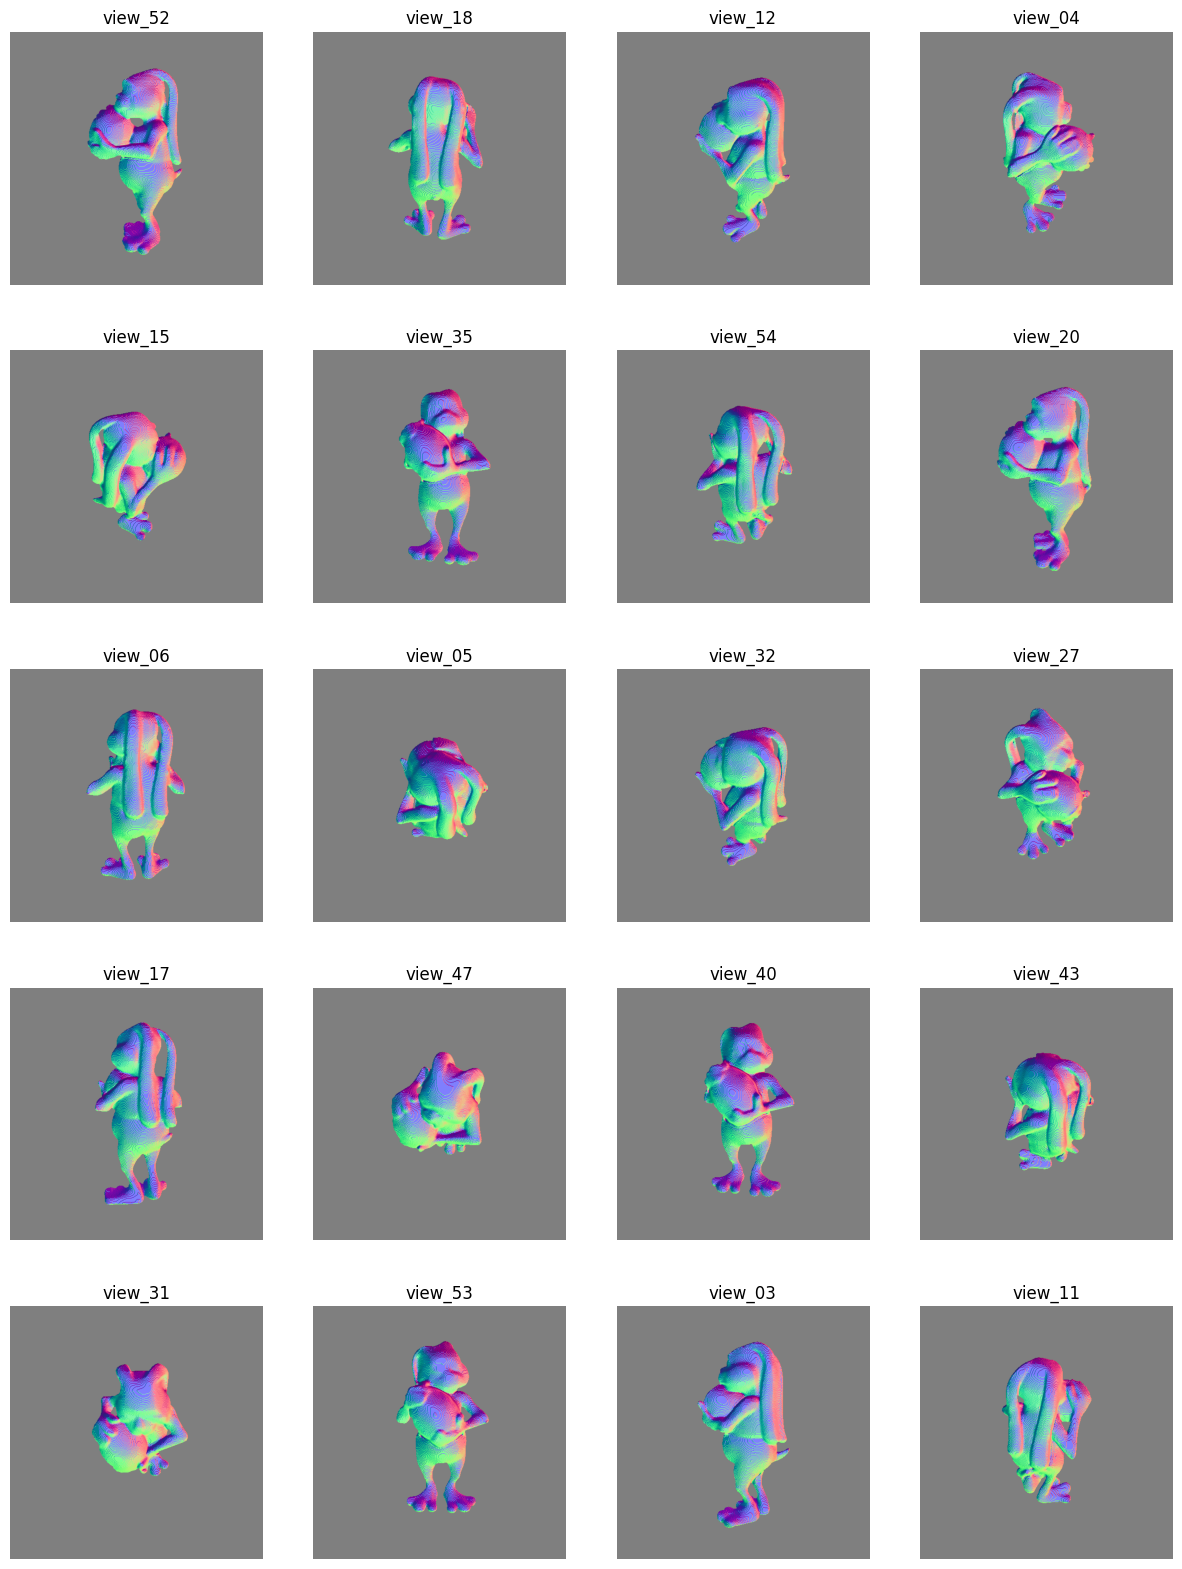

In [4]:
row, col = 5, 4
fig, ax = plt.subplots(row, col, figsize=(15, 20))
for img in range(20):
    depth_image = cv2.imread(depth_imgs[img], cv2.IMREAD_GRAYSCALE).astype(np.float32)
    vec_name = os.path.basename(depth_imgs[img]).split('.')[0][:-6]
    normal_mask_img = cv2.imread(os.path.join(normal_mask_dir, vec_name + '.png')) / 255
    
    if(vec_name == "view_40"):
        normal = get_normal_map_by_point_cloud(depth_image, intrinsic, save_point_cloud=True)
    else:  
        normal = get_normal_map_by_point_cloud(depth_image, intrinsic)
         
    normal = np.pad(normal, ((1, 1), (1, 1), (0, 0)), 'constant', constant_values=0)
    normal = normal * normal_mask_img
    ax[img // col, img % col].imshow(vis_normal(normal))
    ax[img // col, img % col].set_title(f"{vec_name}")
    ax[img // col, img % col].axis('off')

In [13]:
def get_normal_map_by_point_cloud(depth, K, save_point_cloud=False):
    height, width = depth.shape

    def normalization(data):
        normalization = np.linalg.norm(data, axis=-1, keepdims=True)
        return data / (normalization + 1e-8)

    x, y = np.meshgrid(np.arange(0, width), np.arange(0, height))
    x = x.reshape([-1])
    y = y.reshape([-1])
    xyz = np.vstack((x, y, np.ones_like(x)))

    
    
    pts_3d = np.dot(np.linalg.inv(K), xyz * depth.reshape([-1]))
    pts_3d = pts_3d.reshape((3, height, width))

    if(save_point_cloud):
        np.savetxt(f'point_cloud_{CASE_NAME}.xyz', pts_3d.reshape(3, -1).T, delimiter=' ')

    f = (
        pts_3d[:, 1 : height - 1, 2 : width]
        - pts_3d[:, 1 : height - 1, 1 : width - 1]
    )
    t = (
        pts_3d[:, 2:height, 1 : width - 1]
        - pts_3d[:, 1 : height - 1, 1 : width - 1]
    )

    normal_map = np.cross(f, t, axisa=0, axisb=0)
    # print(f"Normalization shape: {np.linalg.norm(normal_map, axis=-1, keepdims=True)}")
    normal_map = normalization(normal_map)

    return normal_map

In [1]:
def load_K_Rt_from_P(filename, P=None):
    if P is None:
        lines = open(filename).read().splitlines()
        if len(lines) == 4:
            lines = lines[1:]
        lines = [[x[0], x[1], x[2], x[3]] for x in (x.split(" ") for x in lines)]
        P = np.asarray(lines).astype(np.float32).squeeze()

    out = cv2.decomposeProjectionMatrix(P)
    K = out[0]
    R = out[1]
    t = out[2]

    K = K / K[2, 2]
    intrinsics = np.eye(4)
    intrinsics[:3, :3] = K

    pose = np.eye(4, dtype=np.float32)
    pose[:3, :3] = R.transpose()
    pose[:3, 3] = (t[:3] / t[3])[:, 0]

    return intrinsics, pose


In [23]:
dummy_img = cv2.imread('/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/bmvs_bear/depth/043_depth.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
H, W = dummy_img.shape

camera_params = np.load('/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/bmvs_bear/cameras_sphere.npz')

world_mat = camera_params['world_mat_43']
scale_mat = camera_params['scale_mat_43']

In [24]:
# apply bilateral filter to depth image
# dummy_img = cv2.bilateralFilter(dummy_img, 15, 50, 50)
# plt.imshow(dummy_img, cmap='gray')

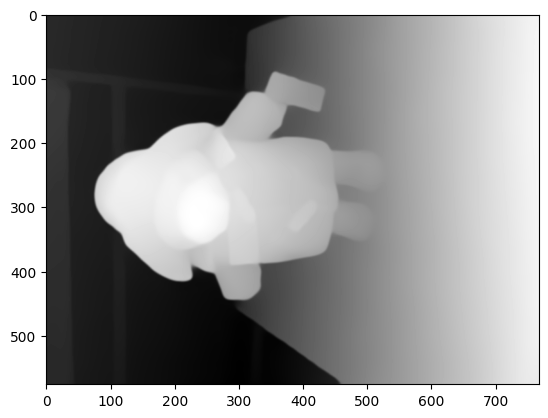

In [17]:
# apply gaussian filter to depth image
import matplotlib.pyplot as plt
dummy_img = cv2.GaussianBlur(dummy_img, (5, 5), 0)
plt.imshow(dummy_img, cmap='gray')

In [25]:
P = world_mat @ scale_mat
P = P[:3, :4]
intrinsics, pose = load_K_Rt_from_P(None, P)

In [26]:
depth_gradient = np.zeros((dummy_img.shape[0], dummy_img.shape[1], 2), dtype=np.float32)

for r in range(1, dummy_img.shape[0] - 1):
    for c in range(1, dummy_img.shape[1] - 1):
        dzdx = (int(dummy_img[r, c+1]) - int(dummy_img[r, c-1])) / 2.0
        dzdy = (int(dummy_img[r+1, c]) - int(dummy_img[r-1, c])) / 2.0

        depth_gradient[r, c] = [dzdx, dzdy]

In [27]:
y, x = np.mgrid[:H, :W]

dX_dx = dummy_img / intrinsics[0, 0] + (x - intrinsics[0, 2]) / intrinsics[0, 0]  * depth_gradient[:, :, 0]
dX_dy = (x - intrinsics[0, 2]) / intrinsics[1, 1]  * depth_gradient[:, :, 1]

dY_dx = (y - intrinsics[1, 2]) / intrinsics[0, 0]  * depth_gradient[:, :, 0]
dY_dy = dummy_img / intrinsics[1, 1] + (y - intrinsics[1, 2]) / intrinsics[1, 1]  * depth_gradient[:, :, 1]

In [28]:
normal_map = np.cross(np.stack([dX_dx, dY_dx, depth_gradient[:, :, 0]], axis=-1), np.stack([dX_dy, dY_dy, depth_gradient[:, :, 1]], axis=-1), axisa=2, axisb=2)

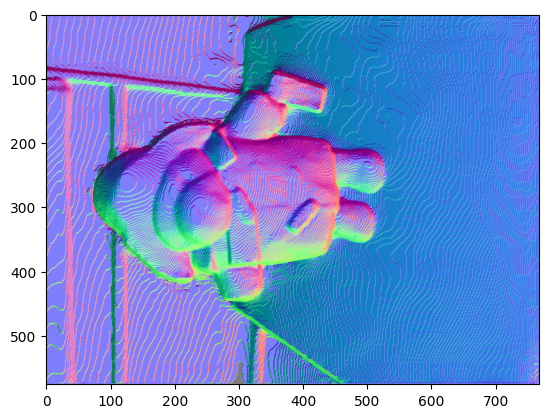

In [29]:
normal_map = normalization(normal_map)
normal_map = np.nan_to_num(normal_map, nan=0.0, posinf=0.0, neginf=0.0)

plt.imshow(vis_normal(normal_map))

In [120]:
normal_vecs[5:6]

['/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/bmvs_bear/normal_estim/043.npy']

043


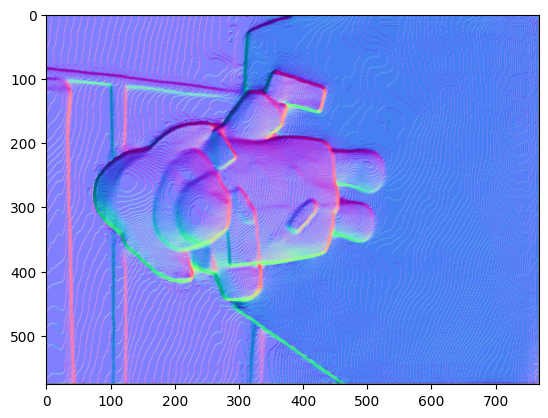

In [121]:
for vec in normal_vecs[5:6]:
    # print view name
    print(os.path.basename(vec).split('.')[0])
    normal_vec = np.load(vec)
    normal_vec = normal_vec * 0.5 + 0.5
    plt.imshow(normal_vec)
    plt.show()

In [28]:
x, y = np.meshgrid(np.arange(0, W), np.arange(0, H))
x = x.reshape([-1])
y = y.reshape([-1])
pixels = np.stack([x, y], axis = -1)


array([[  0,   0],
       [  1,   0],
       [  2,   0],
       ...,
       [197,  99],
       [198,  99],
       [199,  99]])

In [2]:
# central differencing to get the normal vector

def get_normal(depth_img):
    normal_vec = np.zeros((depth_img.shape[0], depth_img.shape[1], 3), dtype=np.float32)
    for r in range(1, depth_img.shape[0] - 1):
        for c in range(1, depth_img.shape[1] - 1):
            dzdx = (int(depth_img[r, c+1]) - int(depth_img[r, c-1])) / 2.0
            dzdy = (int(depth_img[r+1, c]) - int(depth_img[r-1, c])) / 2.0
            normal = np.array([-dzdx, -dzdy, 1.0], dtype=np.float32) # Cross product: (1, 0 , dzdx) x (0, 1, dzdy) = (-dzdx, -dzdy, 1.0)
            normal = normal / np.linalg.norm(normal)
            normal_vec[r, c] = normal
    return normal_vec

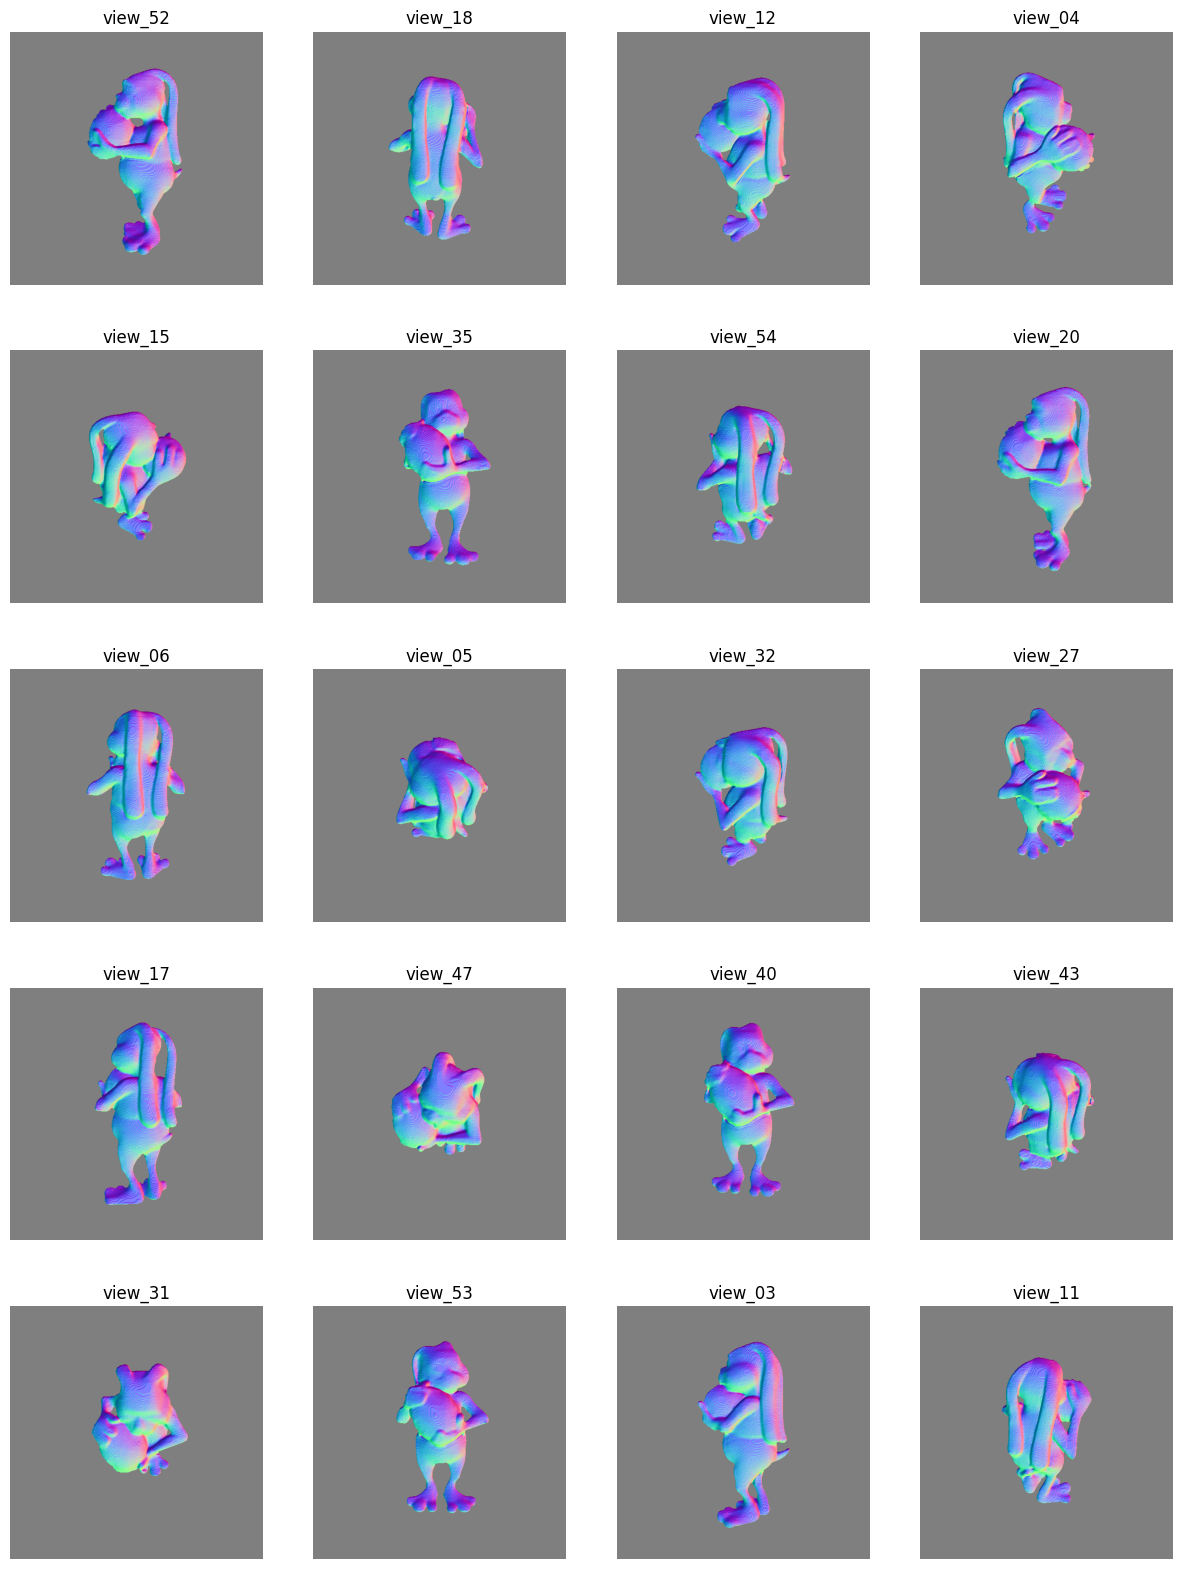

In [6]:
row, col = 5, 4
fig, ax = plt.subplots(row, col, figsize=(15, 20))
for img in range(20):
    depth_image = cv2.imread(depth_imgs[img], cv2.IMREAD_GRAYSCALE).astype(np.float32)
    vec_name = os.path.basename(depth_imgs[img]).split('.')[0][:-6]
    normal_mask_img = cv2.imread(os.path.join(normal_mask_dir, vec_name + '.png')) / 255
    normal = get_normal(depth_image) 
    normal = normal * normal_mask_img
    ax[img // col, img % col].imshow(vis_normal(normal))
    ax[img // col, img % col].set_title(f"{vec_name}")
    ax[img // col, img % col].axis('off')

In [1]:
# Depth image to normal vector
import os
from glob import glob
import cv2
import numpy as np

CASE_NAME = "bmvs_man"

depth_imgs = glob(f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/{CASE_NAME}/depth/*.png")   # Get the list of images
normal_save_dir = f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/{CASE_NAME}/normal_estim"
normal_mask_dir = f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/{CASE_NAME}/mask"
camera_params = np.load('/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/{CASE_NAME}/cameras_sphere.npz')

os.makedirs(normal_save_dir, exist_ok=True)

for img in depth_imgs:
    # Load depth image
    depth_image = cv2.imread(img, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    
    # Estimate normal image
    normal_vec = get_normal(depth_image)

    # Save normal image
    vec_name = os.path.basename(img).split('.')[0][:-6]
    normal_mask_img = cv2.imread(os.path.join(normal_mask_dir, vec_name + '.png')) / 255
    normal_vec = normal_vec * normal_mask_img
    normal_save_path = os.path.join(normal_save_dir, vec_name + '.npy')
    np.save(normal_save_path, normal_vec)

NameError: name 'get_normal' is not defined

In [5]:
# extract image number from depth image path
def extract_img_num(depth_img_path):
    return int(depth_img_path.split('/')[-1].split('_')[0])

extract_img_num(depth_imgs[0])

38

In [7]:
camera_params = np.load(f'/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/{CASE_NAME}/cameras_sphere.npz')
dict(camera_params)

{'camera_mat_0': array([[815.3925 ,   0.     , 386.3475 ,   0.     ],
        [  0.     , 815.3925 , 291.25876,   0.     ],
        [  0.     ,   0.     ,   1.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   1.     ]], dtype=float32),
 'camera_mat_inv_0': array([[ 0.0012264 ,  0.        , -0.47381783,  0.        ],
        [ 0.        ,  0.0012264 , -0.35720068,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32),
 'world_mat_0': array([[ 3.7553848e+02,  8.0797290e+02,  1.4240735e+02, -2.2479752e+02],
        [-7.2408002e+02,  4.4823395e+02,  1.5649561e+02, -9.7771606e+00],
        [-3.5527800e-03,  3.1238899e-01,  9.4994700e-01,  1.2694300e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
       dtype=float32),
 'world_mat_inv_0': array([[ 5.6689890e-04, -1.0875071e-03,  9.4173171e-02, -2.7415119e-03],
        [ 1.0337168e-03,  5.373

In [3]:
def normalization(data):
    normalization = np.linalg.norm(data, axis=-1, keepdims=True)
    return data / (normalization + 1e-8)

def normal_map_from_point_cloud(depth_img, world_mat, scale_mat, save_point_cloud=False):
    H, W = depth_img.shape

    P = world_mat @ scale_mat
    P = P[:3, :4]

    intrinsics, _ = load_K_Rt_from_P(None, P)
    
    depth_gradient = np.zeros((depth_img.shape[0], depth_img.shape[1], 2), dtype=np.float32)

    for r in range(1, depth_img.shape[0] - 1):
        for c in range(1, depth_img.shape[1] - 1):
            dzdx = (int(depth_img[r, c+1]) - int(depth_img[r, c-1])) / 2.0
            dzdy = (int(depth_img[r+1, c]) - int(depth_img[r-1, c])) / 2.0

            depth_gradient[r, c] = [dzdx, dzdy]

    y, x = np.mgrid[:H, :W]

    dX_dx = depth_img / intrinsics[0, 0] + (x - intrinsics[0, 2]) / intrinsics[0, 0]  * depth_gradient[:, :, 0]
    dX_dy = (x - intrinsics[0, 2]) / intrinsics[1, 1]  * depth_gradient[:, :, 1]

    dY_dx = (y - intrinsics[1, 2]) / intrinsics[0, 0]  * depth_gradient[:, :, 0]
    dY_dy = depth_img / intrinsics[1, 1] + (y - intrinsics[1, 2]) / intrinsics[1, 1]  * depth_gradient[:, :, 1]

    normal_map = np.cross(np.stack([dX_dx, dY_dx, depth_gradient[:, :, 0]], axis=-1), np.stack([dX_dy, dY_dy, depth_gradient[:, :, 1]], axis=-1), axisa=2, axisb=2)
    
    normal_map = normalization(normal_map)
    normal_map = np.nan_to_num(normal_map, nan=0.0, posinf=0.0, neginf=0.0)
    
    return normal_map

In [6]:
# Depth image to normal vector
import os
from glob import glob
import cv2
import numpy as np

CASE_NAME = "bmvs_man"

depth_imgs = glob(f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/{CASE_NAME}/depth/*.png")   # Get the list of images
normal_save_dir = f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/{CASE_NAME}/normal_estim_pc"
normal_mask_dir = f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/{CASE_NAME}/mask"
camera_params = np.load(f'/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/{CASE_NAME}/cameras_sphere.npz')

os.makedirs(normal_save_dir, exist_ok=True)

for img in depth_imgs:
    # Load depth image
    depth_image = cv2.imread(img, cv2.IMREAD_GRAYSCALE).astype(np.float64)

    img_id = extract_img_num(img)
    
    # Estimate normal image
    normal_vec = normal_map_from_point_cloud(depth_image, camera_params[f'world_mat_{img_id}'], camera_params[f'scale_mat_{img_id}'])

    # Save normal image
    vec_name = os.path.basename(img).split('.')[0][:-6]
    normal_mask_img = cv2.imread(os.path.join(normal_mask_dir, vec_name + '.png')) / 255
    normal_vec = normal_vec * normal_mask_img
    normal_save_path = os.path.join(normal_save_dir, vec_name + '.npy')
    np.save(normal_save_path, normal_vec)

KeyboardInterrupt: 

In [14]:
# Depth image to normal vector
import os
from glob import glob
import cv2
import numpy as np

CASE_NAME = "scan24"

depth_imgs = glob(f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/DTU_sfm/{CASE_NAME}/depth/*.png")   # Get the list of images
normal_save_dir = f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/DTU_sfm/{CASE_NAME}/normal_estim_pc"
normal_mask_dir = f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/DTU_sfm/{CASE_NAME}/mask"
camera_params = np.load(f'/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/DTU_sfm/{CASE_NAME}/cameras.npz')

os.makedirs(normal_save_dir, exist_ok=True)

for img in depth_imgs:
    # Load depth image
    depth_image = cv2.imread(img, cv2.IMREAD_GRAYSCALE).astype(np.float64)

    img_id = extract_img_num(img)
    
    # Estimate normal image
    normal_vec = normal_map_from_point_cloud(depth_image, camera_params[f'world_mat_{img_id}'], camera_params[f'scale_mat_{img_id}'])

    # Save normal image
    vec_name = os.path.basename(img).split('.')[0][:-6][-3:]
    normal_mask_img = cv2.imread(os.path.join(normal_mask_dir, vec_name + '.png')) / 255
    normal_vec = normal_vec * normal_mask_img
    normal_save_path = os.path.join(normal_save_dir, vec_name + '.npy')
    np.save(normal_save_path, normal_vec)

In [28]:
from glob import glob
import os
import matplotlib.pyplot as plt

# CASE_NAME = "bmvs_bear"
# normal_vecs = glob(f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/{CASE_NAME}/normal_estim_pc/*.npy")   # Get the list of images
CASE_NAME = "scan24"
normal_vecs = glob(f"/home/ojaswa/aarya/research_papers_implementation/NeuS/public_data/BlendedMVS/{CASE_NAME}/normal_estim_pc/*.npy")   # Get the list of images

041


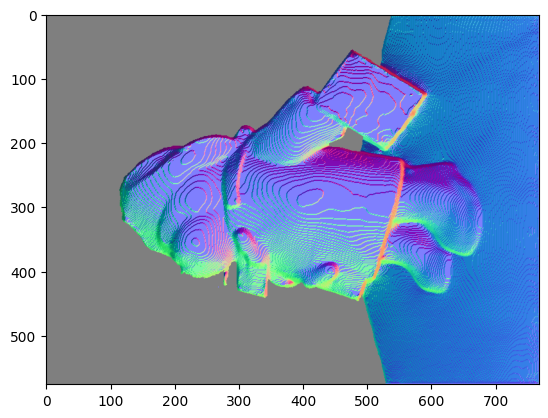

065


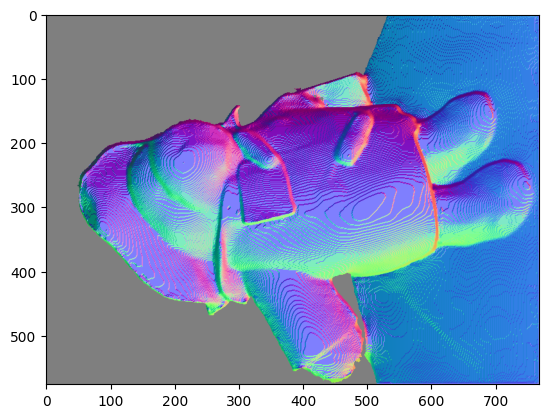

111


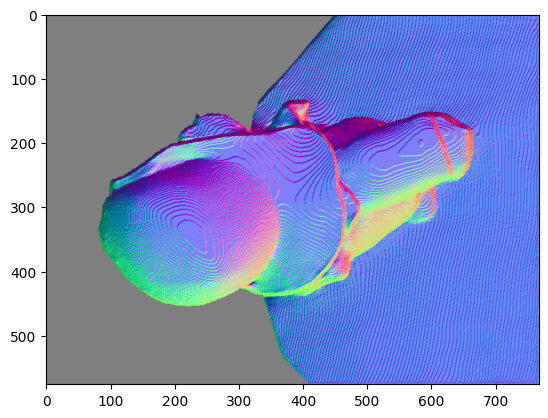

038


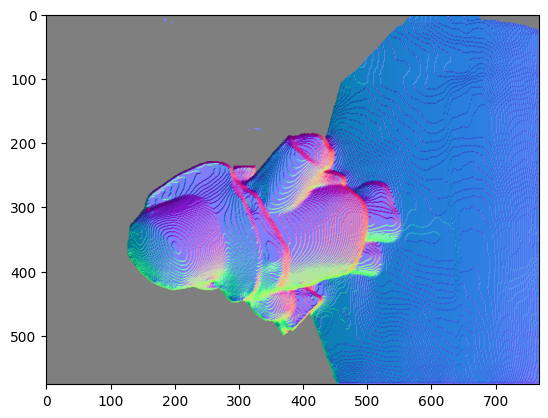

108


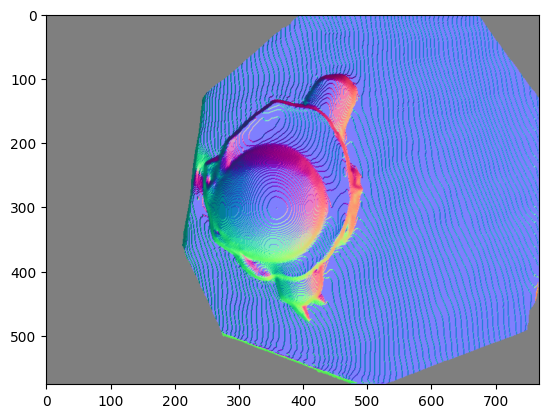

088


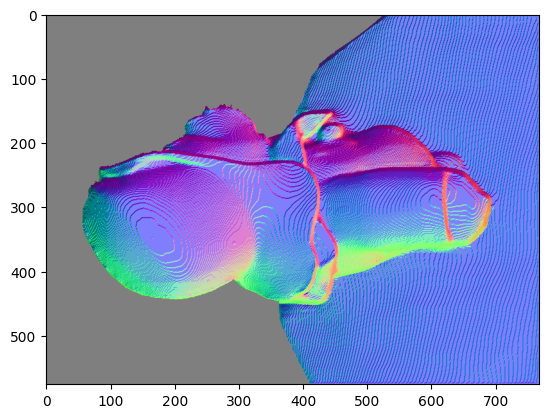

060


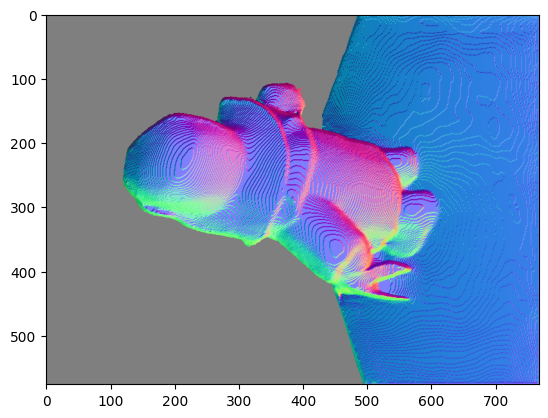

040


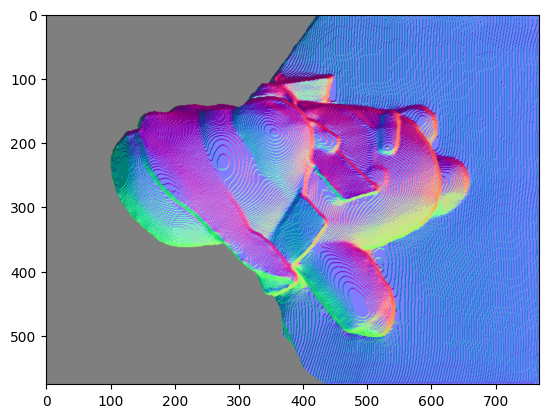

043


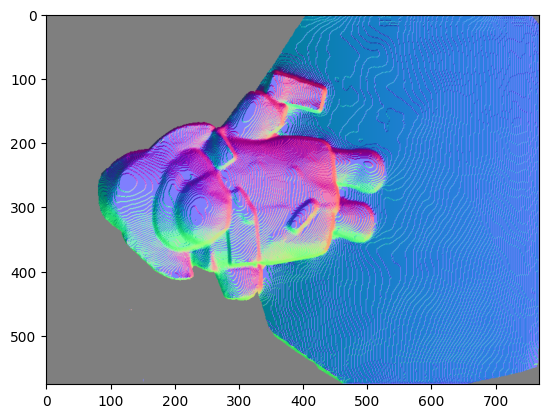

098


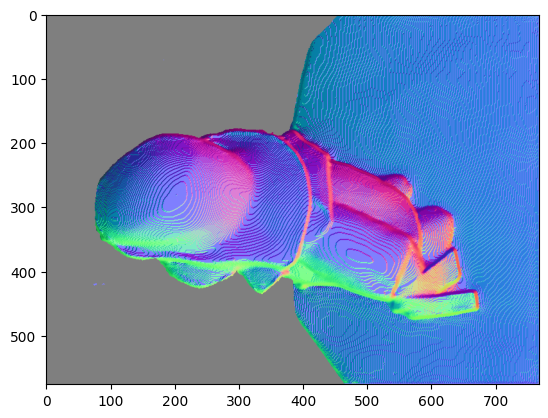

081


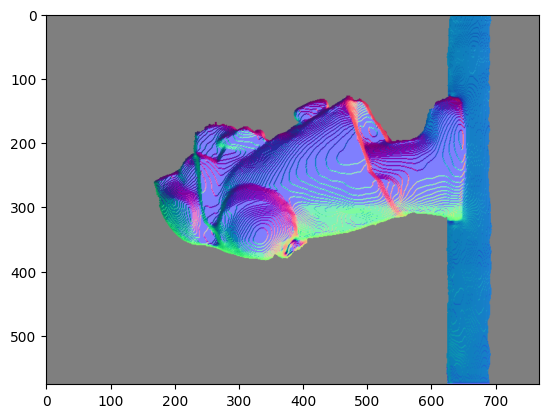

036


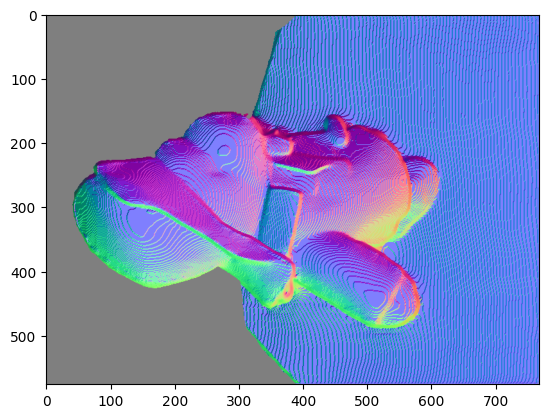

042


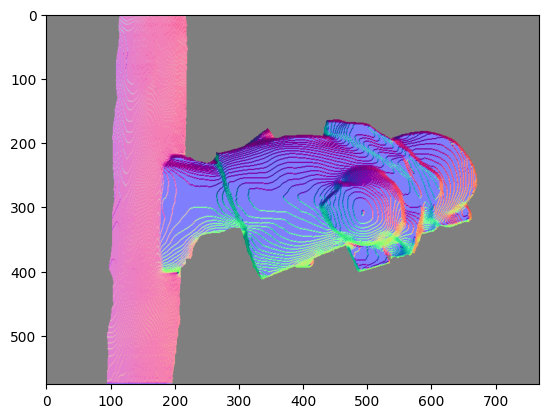

114


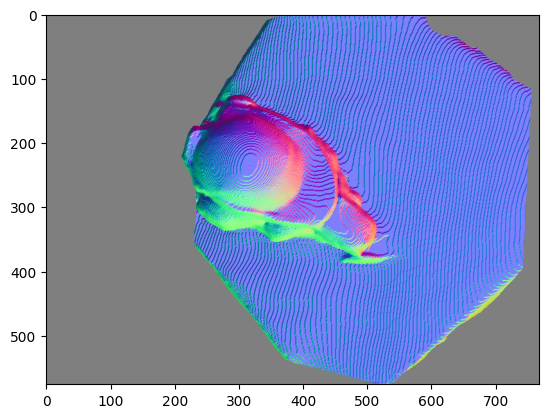

058


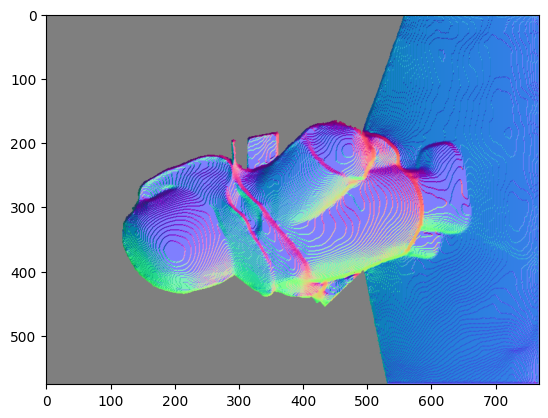

In [29]:
for vec in normal_vecs[:15]:
    # print view name
    print(os.path.basename(vec).split('.')[0])
    normal_vec = np.load(vec)
    normal_vec = normal_vec * 0.5 + 0.5
    plt.imshow(normal_vec)
    plt.show()